In [3]:
import astropy.io.fits as fits
import fitsio
import astropy.utils.data as datautils
import astropy.table as table
import pandas
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import get_pkg_data_filename
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# 1. Luminosity Function with 1/Vmax method

*Author: Nigel Shen*

Download a catalog SDSS Legacy Survey galaxies in the Main Sample between redshifts
0.01 < z < 0.2. Estimate the shape of the luminosity function in the r-band using the 1/Vmax
method. In calculating Vmax and luminosities, ignore both K-corrections and evolution of
the population; a precise estimate would require estimating both, but in the r-band it is
approximately the case that these effects cancel. Also account only for the redshift selection
effects, and for the angular selection effects simply assume an effective area of 7500 square
degrees.

We download data from https://skyserver.sdss.org/casjobs/ with the following SQL code to select our data, using the condition that the galaxies are from the Main Sample (the condition on legacy_target1), which has a flux limit of $r< 17.77$ over most of the covered sky:

``select p.objid, p.r, s.z as redshift
from galaxy p, specobj s
where p.objid=s.bestobjid and s.z BETWEEN 0.01 AND 0.2
and (s.legacy_target1 & 64) > 0``

In [4]:
galaxies = fitsio.read('galaxies.fits')

We draw a joint distribution of distance and absolute magnitude in the r-band. The distance is calculated using Hubble's Law: 

$$D=\frac{cz}{H_0}$$

Notice that $D$ is in Mpc, so the absolute magnitude is calculated using:

$$M_r=m-5\log_{10}\left(D\right) - 25$$ 

We can see that galaxies are sparse on the left part where $D<100 Mpc$.

We also want to find the maximum distance versus absolute magnitude. Suppose the faintest apparent magnitude that can be detected is $17.77$, then we approximate (ignoring evolution and K-corrections):

$$M_{r} = 17.77 - 5\log_{10}\left( D_{max}\right) - 25$$

Indeed, the red curve representing maximum distance versus absolute magnitude fits well the scatter plot. Due to redshift selection effect, the distance bandwidth is $D\in[44, 882]\ (Mpc)$

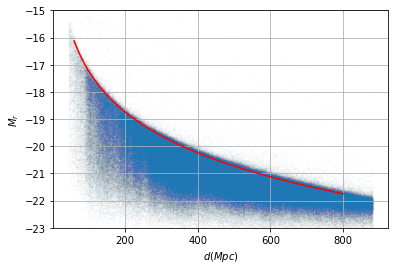

In [7]:
H0 = 68.  # km/s/Mpc
d = galaxies['redshift'] * 2.99792e+5 / H0  # In Mpc
Mabs = galaxies['r'] - 5 * np.log10(d) - 25  # Absolute magnitude
plt.scatter(d, Mabs, s=0.2, alpha=0.02)
plt.xlabel('$d (Mpc)$')
plt.ylabel('$M_r$')
plt.grid()

dgrid = np.linspace(60, 800, 100)
Mabs_max = 17.77 - 5. * np.log10(dgrid) - 25.
plt.plot(dgrid, Mabs_max, color='r')
plt.ylim([-23., -15.])
plt.show()

We now draw a joint distribution of volume enclosed and absolute magnitude in the r-band. The volume is calculated as:$$V=\frac{\Omega}{3}D^3$$ where $\Omega=7500\times\left(\frac{\pi}{180}\right)^2$. Notice that the distribution over the x-axis is nearly uniform.

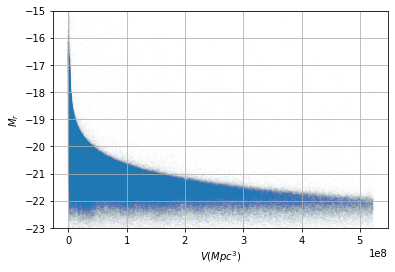

In [9]:
V = (7500/180**2)*np.pi**2*d ** 3/3 # Volume
plt.scatter(V, Mabs, s=0.2, alpha=0.02)
plt.xlabel('$V (Mpc^3)$')
plt.ylabel('$M_r$')
plt.ylim([-23., -15.])
plt.grid()
plt.show()

We then approximate the luminosity function $\Phi(M_r)$ by making a plot over the interval $M_r\in[-12,-24]$ using $V_{max}$ method. The maximum distance is approximated using:$$D_{max}=10^{-(M_{r}+7.23)/5}$$

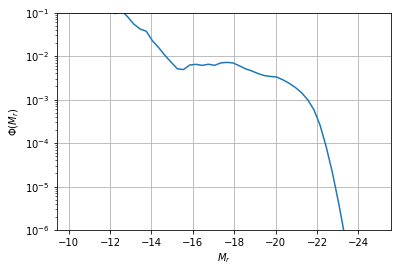

In [12]:
dmax = 10**(-(Mabs+7.23)/5)
Vmax = (7500/360**2)*(4/3)*np.pi**2*dmax ** 3# Volume
Mmax, Mmin = -10, -25
H = (Mmax-Mmin)/50
intervals = np.linspace(Mmin, Mmax, 50, endpoint=False)+H/2
phi = np.zeros(50)
for i in range(galaxies.shape[0]):
    index = int(np.floor((Mabs[i]+25)/H))
    if index < 50:
        phi[index] = phi[index]+1/(H*Vmax[i])
plt.plot(intervals, phi)
plt.yscale('log')
plt.ylim(10**-6, 10**-1)
plt.ylabel('$\Phi(M_r)$')
plt.xlabel('$M_r$')
plt.grid()
plt.gca().invert_xaxis()

### 3. Galaxy colors and spectra

*Author: Jiarong Zhu*

Download the catalog of galaxies from the NASA Sloan Atlas between redshifts 0.01 < z < 0.05. Plot their absolute magnitude vs. color. Select several galaxies along the red and blue sequences, and download and show their color images. For the same galaxies, download from the SDSS database their spectra. Zoom in on the Hα region and the 4000 Aregion. Comment on the major differences between the blue and red galaxies.

In [22]:
nsa_file = datautils.download_file('http://sdss.physics.nyu.edu/mblanton/v0/nsa_v0_1_2.fits', cache=True)
hdul = fits.open(nsa_file)

In [23]:
z=hdul[1].data['Z']

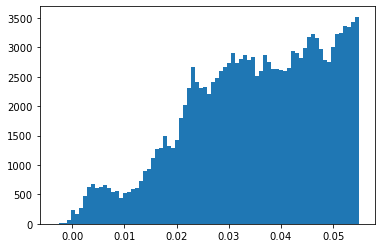

In [24]:
_ = plt.hist(z, bins='auto')  

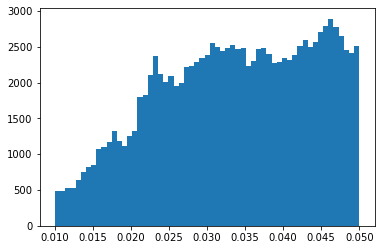

In [25]:
N = len(z)

#locate the data such that 0.01<z<0.05
index = np.where(abs(z-0.03)<0.02)  
data = hdul[1].data[index]

_ = plt.hist(data['Z'], bins='auto')  


In [26]:
mag = data['ABSMAG']  # absmag of FNugriz
x = mag[:,4]
y = mag[:,3]-mag[:,4]

(-24.0, -13.0)

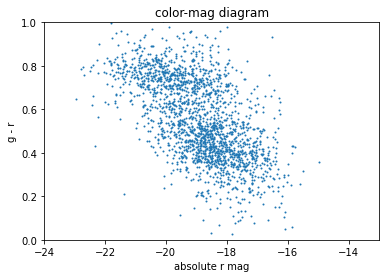

In [27]:
_ = plt.scatter(x[0:2000],y[0:2000],s=1) # I didn't use all data because I want to see the seperation of blue
# and red sequencies more clearly
plt.gca().invert_xaxis()
plt.ylabel('g - r')
plt.xlabel('absolute r mag')
plt.ylim(0,1)
plt.title('color-mag diagram')
plt.xlim(-24,-13)

In [28]:
i_red = []
i_blue = []

for i in range(len(y)):
    if abs(y[i]-0.3)<0.001: # find index of blue galaxies with g-r~0.03
        i_blue.append(i)
    elif abs(y[i]-0.8)<0.001: # find index of red galaxies with g-r~0.08
        i_red.append(i)
    
print(i_red[0:10])
print(i_blue[0:10])

[6, 27, 145, 190, 368, 966, 1320, 1915, 1940, 2186]
[71, 798, 887, 1159, 1717, 2855, 2928, 3521, 4132, 4928]


In [29]:
# randomly select 2 blue galaxies and 2 red galaxies, find their nsaid
indxs = np.array([27, 1320, 887, 3521])
print(data['NSAID'][indxs])

[  46 1675 1106 5022]


In [47]:
jpgurls = 'http://sdss.physics.nyu.edu/mblanton/v0/detect/v0_0/' + data['SUBDIR'][indxs] + '/' + data['IAUNAME'][indxs] + '.cutout.jpg'
jpgs = []
for jpgurl in jpgurls:
    jpgs.append(datautils.download_file(jpgurl))

[ 'http://sdss.physics.nyu.edu/mblanton/v0/detect/v0_0/09h/p00/J094404.05+004300.4/J094404.05+004300.4.cutout.jpg'
 'http://sdss.physics.nyu.edu/mblanton/v0/detect/v0_0/12h/m00/J125618.46-010155.9/J125618.46-010155.9.cutout.jpg'
 'http://sdss.physics.nyu.edu/mblanton/v0/detect/v0_0/11h/p00/J112858.10+005244.4/J112858.10+005244.4.cutout.jpg'
 'http://sdss.physics.nyu.edu/mblanton/v0/detect/v0_0/22h/m00/J220925.60-000633.1/J220925.60-000633.1.cutout.jpg']


In [48]:
specurls = []
specs = []
specurl_template =  'https://dr16.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/{plate:04d}/spec-{plate:04d}-{mjd}-{fiberid:04d}.fits'
for indx in indxs:
    specurls.append(specurl_template.format(plate=data['PLATE'][indx], mjd=data['MJD'][indx], fiberid=data['FIBERID'][indx]))
for specurl in specurls:
    specs.append(datautils.download_file(specurl))

The first two are red galaxies. In both cases, the spectra look similar to red giant spectra. There is a distinct "break" in the spectrum at 4000 Angstroms. Near H$\alpha$, in the first case there is a weak absorption line, and in the second there is a weak emission line. For an old population, we expect a weak absorption line from the stellar population; emission will be from ionized gas associated with either a small amount of star formation or with weak LINER or AGN activity. For weak lines like this, to disentangle how much emission vs. absorption there is requires detailed modeling (using other regions of the spectrum and stellar population modeling to predict the H$\alpha$ absorption).

In [87]:
i = 0
spec = specs[i]
jpg = jpgs[i]

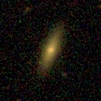

In [88]:
Image(filename=jpg, format='jpg')

Text(0, 0.5, 'Flux')

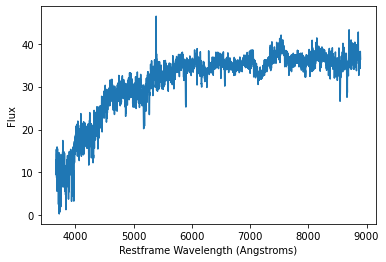

In [89]:
ds = fits.open(spec)
wave = 10**ds[1].data['loglam'] / (1. + data['Z'][indxs[i]])
flux = ds[1].data['flux']
plt.plot(wave, flux)
plt.xlabel('Restframe Wavelength (Angstroms)')
plt.ylabel('Flux')

Text(0.5, 1.0, 'Spectrum near 4000 A')

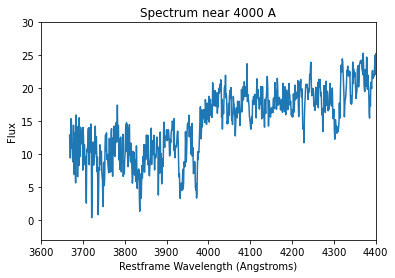

In [90]:
plt.plot(wave, flux)
plt.xlabel('Restframe Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.xlim([3600., 4400.])
plt.ylim([-3., 30.])
plt.title('Spectrum near 4000 A')

Text(0.5, 1.0, 'Spectrum near Halpha 6563 A')

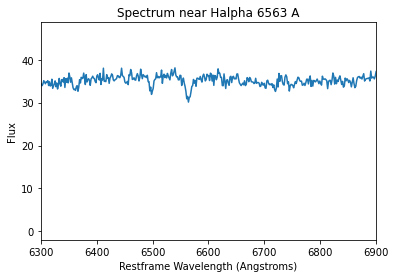

In [91]:
plt.plot(wave, flux)
plt.xlabel('Restframe Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.xlim([6300., 6900.])
plt.title('Spectrum near Halpha 6563 A')

In [92]:
i = 1
spec = specs[i]
jpg = jpgs[i]

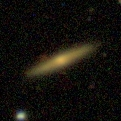

In [93]:
Image(filename=jpg, format='jpg')

Text(0, 0.5, 'Flux')

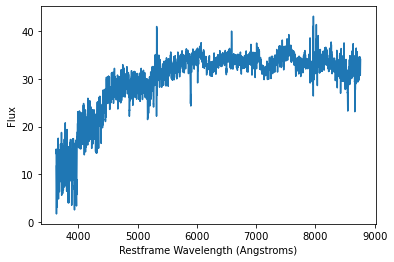

In [94]:
ds = fits.open(spec)
wave = 10**ds[1].data['loglam'] / (1. + data['Z'][indxs[i]])
flux = ds[1].data['flux']
plt.plot(wave, flux)
plt.xlabel('Restframe Wavelength (Angstroms)')
plt.ylabel('Flux')

Text(0.5, 1.0, 'Spectrum near 4000 A')

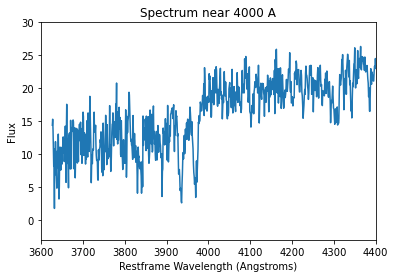

In [95]:
plt.plot(wave, flux)
plt.xlabel('Restframe Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.xlim([3600., 4400.])
plt.ylim([-3., 30.])
plt.title('Spectrum near 4000 A')

Text(0.5, 1.0, 'Spectrum near Halpha 6563 A')

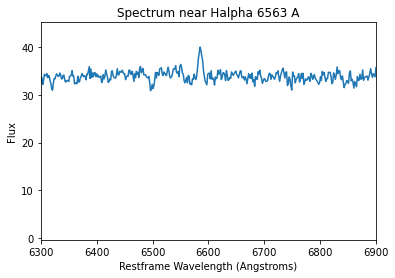

In [96]:
plt.plot(wave, flux)
plt.xlabel('Restframe Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.xlim([6300., 6900.])
plt.title('Spectrum near Halpha 6563 A')

The second two are blue galaxies. The 4000 A breaks are clearly weaker. The Balmer absorption lines visible in that region (especially for the second one) are clear, and the slope of the spectrum is blue, clearly indicating a young stellar population. Around H$\alpha$, there is very strong emission associated with the star formation. Note that there will *also* be fairly deep H$\alpha$ absorption in these galaxies, and accounting for this absorption is important for accurate measurements of the emission lines, but it is overwhelmed by the emission and so not apparent on casual inspection. 

In [110]:
i = 2
spec = specs[i]
jpg = jpgs[i]

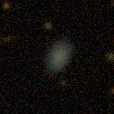

In [111]:
Image(filename=jpg, format='jpg')

Text(0, 0.5, 'Flux')

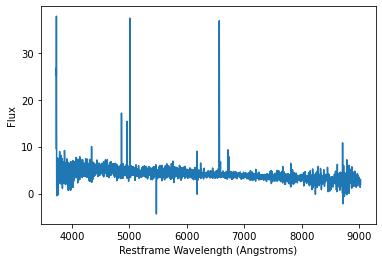

In [112]:
ds = fits.open(spec)
wave = 10**ds[1].data['loglam'] / (1. + data['Z'][indxs[i]])
flux = ds[1].data['flux']
plt.plot(wave, flux)
plt.xlabel('Restframe Wavelength (Angstroms)')
plt.ylabel('Flux')

Text(0.5, 1.0, 'Spectrum near 4000 A')

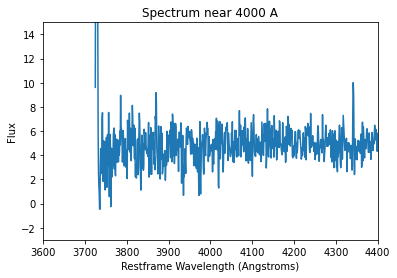

In [114]:
plt.plot(wave, flux)
plt.xlabel('Restframe Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.xlim([3600., 4400.])
plt.ylim([-3., 15.])
plt.title('Spectrum near 4000 A')

Text(0.5, 1.0, 'Spectrum near Halpha 6563 A')

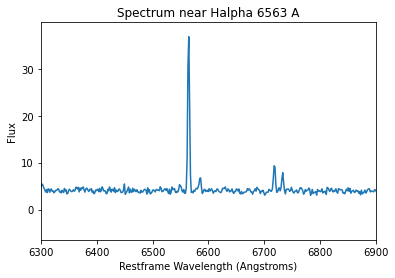

In [115]:
plt.plot(wave, flux)
plt.xlabel('Restframe Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.xlim([6300., 6900.])
plt.title('Spectrum near Halpha 6563 A')

In [116]:
i = 3
spec = specs[i]
jpg = jpgs[i]

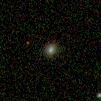

In [117]:
Image(filename=jpg, format='jpg')

Text(0, 0.5, 'Flux')

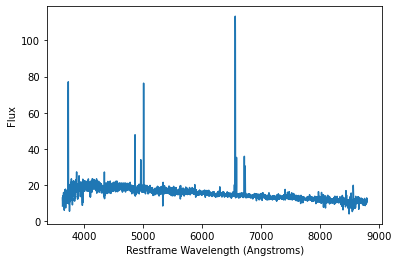

In [118]:
ds = fits.open(spec)
wave = 10**ds[1].data['loglam'] / (1. + data['Z'][indxs[i]])
flux = ds[1].data['flux']
plt.plot(wave, flux)
plt.xlabel('Restframe Wavelength (Angstroms)')
plt.ylabel('Flux')

Text(0.5, 1.0, 'Spectrum near 4000 A')

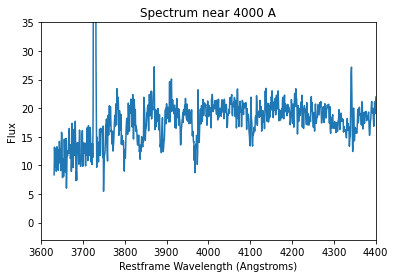

In [119]:
plt.plot(wave, flux)
plt.xlabel('Restframe Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.xlim([3600., 4400.])
plt.ylim([-3., 35.])
plt.title('Spectrum near 4000 A')

Text(0.5, 1.0, 'Spectrum near Halpha 6563 A')

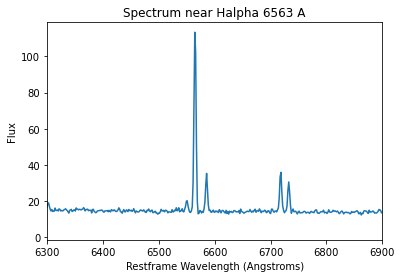

In [120]:
plt.plot(wave, flux)
plt.xlabel('Restframe Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.xlim([6300., 6900.])
plt.title('Spectrum near Halpha 6563 A')

Generaly speaking, the spectrum reflects the color. Blue galaxies look blue while red galaxies look red, meaning the stellar populations have different temperatures.

Blue galaxies have strong emission in the Balmer series, such as H$\alpha$ emission, and significant emission in collisionally excited species such as OII, OIII, while red galaxies don't have that signature. Keyword: emission.

Red galaxies have a clear drop off in intensity blueward of 4000 A, which indicates composition of old stellar population and lack of hot blue stars. Blue galaxies don't have that. Keyword: absorption.

### 4.  Edge-on and face-on galaxies

*Author: Matthew Daunt*

In [64]:
nsa_file = datautils.download_file('http://sdss.physics.nyu.edu/mblanton/v0/nsa_v0_1_2.fits', cache=True)
hdu_list = fits.open(nsa_file, memmap=True)

evt_table = table.Table(hdu_list[1].data)

g_r = evt_table['ABSMAG'][:, 3] - evt_table['ABSMAG'][:, 4]
ba = evt_table['BA90']

# clean the b/a columns of nans
clean =  np.isfinite(ba) & (g_r > 0.) & (g_r < 1.)
g_r_clean     = g_r[clean]
b_a_clean     = ba[clean]
s_n_clean     = evt_table['SERSIC_N'][clean]
subdir_clean  = evt_table['SUBDIR'][clean]
iauname_clean = evt_table['IAUNAME'][clean]

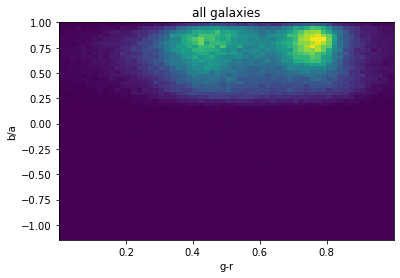

In [65]:
NBINS = (60, 60)
plt.hist2d(g_r_clean, b_a_clean, NBINS, cmap='viridis')
plt.title('all galaxies')
plt.xlabel('g-r')
plt.ylabel('b/a')
plt.show()

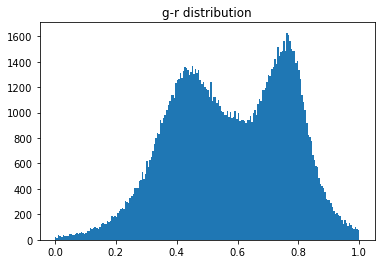

In [66]:
plt.hist(g_r_clean,bins=200)
plt.title('g-r distribution')
plt.show()

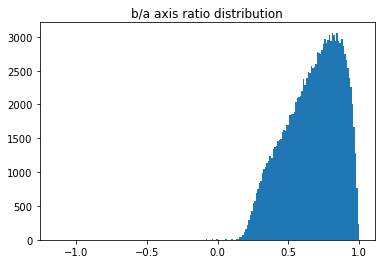

In [67]:
plt.hist(b_a_clean,bins=200)
plt.title('b/a axis ratio distribution')
plt.show()


In [81]:
red_clean = np.isfinite(ba) & (g_r > 0.65) & (g_r < 1.) & (ba >= 0)
blue_clean = np.isfinite(ba) & (g_r < 0.65) & (g_r > 0.) & (ba >= 0)

red_lown_clean = (np.isfinite(ba) & (g_r > 0.65) & (g_r < 1.)
                  & (ba >= 0) & (evt_table['SERSIC_N'] < 2.))
blue_lown_clean = (np.isfinite(ba) & (g_r < 0.65) & (g_r > 0.)
                   & (ba >= 0) & (evt_table['SERSIC_N'] < 2.))

red_highn_clean = (np.isfinite(ba)  & (g_r > 0.65) & (g_r < 1.)
                  & (ba >= 0) & (evt_table['SERSIC_N'] > 2.))
blue_highn_clean = (np.isfinite(ba) & (g_r < 0.65) & (g_r > 0.)
                   & (ba >= 0) & (evt_table['SERSIC_N'] > 2.))

lown_clean = (np.isfinite(ba)  & (g_r > 0.0) & (g_r < 1.)
                & (ba >= 0) & (evt_table['SERSIC_N'] < 2.))

highn_clean = (np.isfinite(ba)  & (g_r > 0.0) & (g_r < 1.)
                & (ba >= 0) & (evt_table['SERSIC_N'] > 2.))

lown_lowlum_clean = (np.isfinite(ba)  & (g_r > 0.0) & (g_r < 1.)
                     & (ba >= 0) & (evt_table['SERSIC_N'] < 2.)
                     & (evt_table['ABSMAG'][:, 4] > -19.5))

lown_highlum_clean = (np.isfinite(ba)  & (g_r > 0.0) & (g_r < 1.)
                     & (ba >= 0) & (evt_table['SERSIC_N'] < 2.)
                     & (evt_table['ABSMAG'][:, 4] < -19.5))

ba_red = ba[red_clean]
ba_blue = ba[blue_clean]

ba_lown = ba[lown_clean]
ba_highn = ba[highn_clean]

ba_lown_lowlum = ba[lown_lowlum_clean]
ba_lown_highlum = ba[lown_highlum_clean]

ba_red_lown = ba[red_lown_clean]
ba_blue_lown = ba[blue_lown_clean]

ba_red_highn = ba[red_highn_clean]
ba_blue_highn = ba[blue_highn_clean]

g_r_red = g_r[red_clean]
g_r_blue = g_r[blue_clean]

g_r_highn = g_r[highn_clean]
g_r_lown = g_r[lown_clean]

g_r_red_lown = g_r[red_lown_clean]
g_r_blue_lown = g_r[blue_lown_clean]

g_r_red_highn = g_r[red_highn_clean]
g_r_blue_highn = g_r[blue_highn_clean]

g_r_lown_lowlum = g_r[lown_lowlum_clean]
g_r_lown_highlum = g_r[lown_highlum_clean]

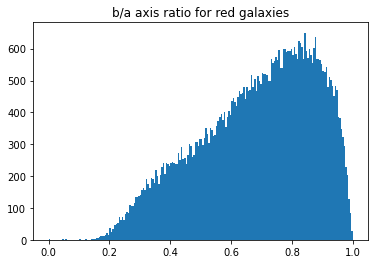

In [69]:
plt.hist(ba_red,bins=200)
plt.title('b/a axis ratio for red galaxies')
plt.show()

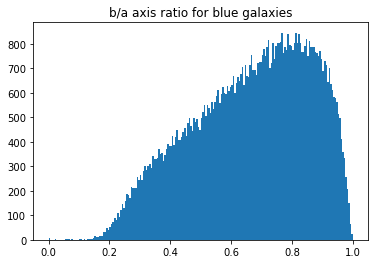

In [70]:
plt.hist(ba_blue,bins=200)
plt.title('b/a axis ratio for blue galaxies')
plt.show()

For high Sersic index galaxies there is no obvious relationship between color and $b/a$.

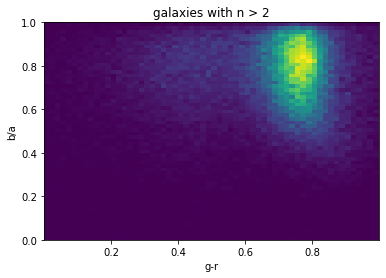

In [76]:
plt.hist2d(g_r_highn, ba_highn, NBINS, cmap='viridis')
plt.title('galaxies with n > 2')
plt.xlabel('g-r')
plt.ylabel('b/a')
plt.show()

For low Sersic index galaxies, the red galaxies are preferentially low $b/a$. This trend indicates that red, low-Sersic index galaxies are likely dust-reddened disks seen edge-on. However, there are also edge-on (i.e. low $b/a$) disks that are not red, indicating that dust, or at least dust reddening, is not present in all low Sersic index systems.

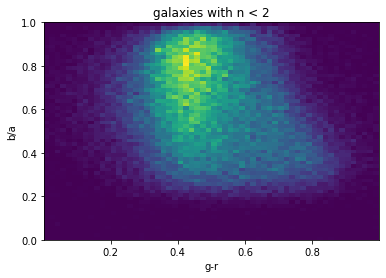

In [73]:
plt.hist2d(g_r_lown, ba_lown, NBINS, cmap='viridis')
plt.title('galaxies with n < 2')
plt.xlabel('g-r')
plt.ylabel('b/a')
plt.show()

Digging a bit deeper, we find that the high luminosity galaxies have a clearer relationship between $b/a$ and reddening, whereas the colors of low luminosity galaxies are much less related to $b/a$. This indicates that high luminosity exponential-disk galaxies have more dust than low luminosity ones. 

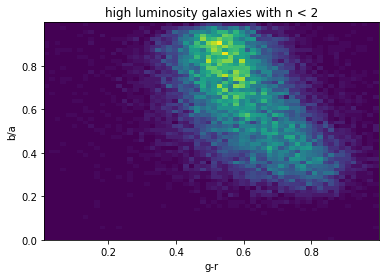

In [85]:
plt.hist2d(g_r_lown_highlum, ba_lown_highlum, NBINS, cmap='viridis')
plt.title('high luminosity galaxies with n < 2')
plt.xlabel('g-r')
plt.ylabel('b/a')
plt.show()

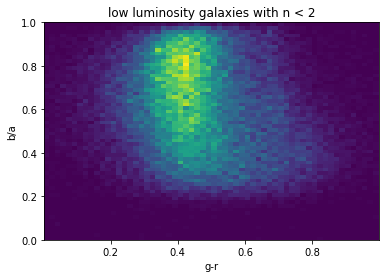

In [86]:
plt.hist2d(g_r_lown_lowlum, ba_lown_lowlum, NBINS, cmap='viridis')
plt.title('low luminosity galaxies with n < 2')
plt.xlabel('g-r')
plt.ylabel('b/a')
plt.show()

If we look at a random sampling of high luminosity, low Sersic index galaxies in increasing order of $b/a$, we sort of see the effect. There is clear dust reddening in dust lanes for the low $b/a$ galaxies. Note however that there is a lot of variety in the forms the galaxies take!

In [209]:
np.random.seed(112)
indxs = np.random.choice(np.where(lown_highlum_clean)[0], 10)
indxs = indxs[np.argsort(evt_table['BA90'][indxs])]
jpgurls = 'http://sdss.physics.nyu.edu/mblanton/v0/detect/v0_0/' + hdu_list[1].data['SUBDIR'][indxs] + '/' + hdu_list[1].data['IAUNAME'][indxs] + '.cutout.jpg'
jpgs = []
for jpgurl in jpgurls:
    jpgs.append(datautils.download_file(jpgurl))

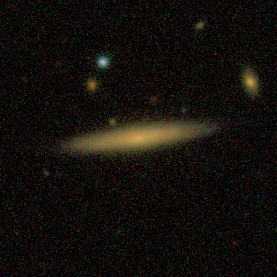

In [210]:
Image(filename=jpgs[0], format='jpg')

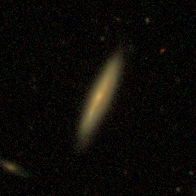

In [211]:
Image(filename=jpgs[1], format='jpg')

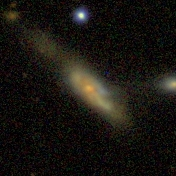

In [212]:
Image(filename=jpgs[2], format='jpg')

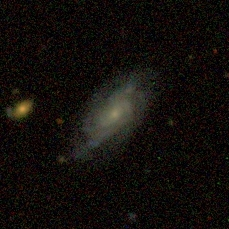

In [213]:
Image(filename=jpgs[3], format='jpg')

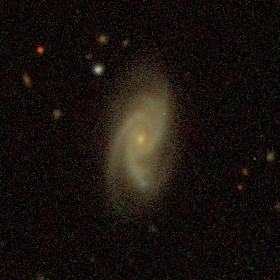

In [214]:
Image(filename=jpgs[4], format='jpg')

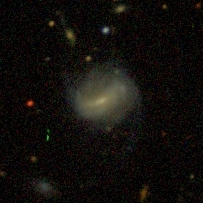

In [215]:
Image(filename=jpgs[5], format='jpg')

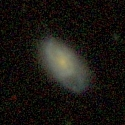

In [216]:
Image(filename=jpgs[6], format='jpg')

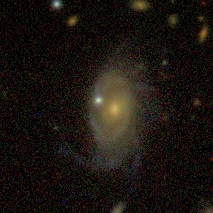

In [217]:
Image(filename=jpgs[7], format='jpg')

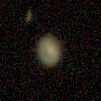

In [218]:
Image(filename=jpgs[8], format='jpg')

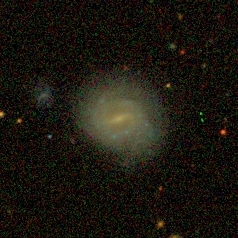

In [219]:
Image(filename=jpgs[9], format='jpg')